# Importing Libraries

In [8]:
import pandas as pd
import requests
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Loading MTA Data

In [9]:
# Create a function to apply a date to the MTA format URL for each .txt file

def url_creator(date):
    ''' 
    A function to apply a date to the MTA format URL for each .txt file
    '''
    return "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt".format(date)

In [10]:
# Create a function to return all saturdays 

def saturdays(start_date,end_date):
    ''' 
    A function to return all saturdays within two given dates
    '''
    dates = pd.date_range(start = start_date,end = end_date ,freq='W-SAT').strftime('%y%m%d').tolist()
    return dates

start_date = "2020-01-01"
end_date = "2021-01-01"

dates = saturdays(start_date, end_date)
print(dates)

['200104', '200111', '200118', '200125', '200201', '200208', '200215', '200222', '200229', '200307', '200314', '200321', '200328', '200404', '200411', '200418', '200425', '200502', '200509', '200516', '200523', '200530', '200606', '200613', '200620', '200627', '200704', '200711', '200718', '200725', '200801', '200808', '200815', '200822', '200829', '200905', '200912', '200919', '200926', '201003', '201010', '201017', '201024', '201031', '201107', '201114', '201121', '201128', '201205', '201212', '201219', '201226']


In [11]:
# creat a list of dataframe's to concat
list_df = []

# add all .txt files uplodaed for the given dates using the Saturday's function to a single dataframe

for date in dates:
    # creating a variable holding the basurl for a given date

    base_url = url_creator(date)
    # add and read each file to a dataframe and add it to the list to be concated
    
    df = pd.read_csv(str(base_url),parse_dates = [['DATE','TIME']],index_col = 'DATE_TIME')
    list_df.append(df)

In [12]:
# Consolidate all weekly dataframes into one data frame

consolidated_mta_data = pd.concat(list_df)

In [13]:
# Save data frame to local 

consolidated_mta_data.to_csv('consolidated_mta_data.csv')

In [14]:
# Load dataframe 

df = pd.read_csv("consolidated_mta_data.csv")
df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS
0,2019-12-28 03:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7324295,2482512
1,2019-12-28 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7324305,2482523
2,2019-12-28 11:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7324371,2482594
3,2019-12-28 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7324587,2482647
4,2019-12-28 19:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7324963,2482713


# Historical Weather in NYC

## 1) Loading Data

In [15]:
# add access token from the National Oceanic and Atmospheric Administration (NOAA)

token = 'ezGtBYtHkPAhGoeilnLTAThlLXnAQIiF'

In [16]:
# Add id for Central Park weather station

station_id = "GHCND:USW00094728"

In [17]:
# Create a list of variables to be included in the api call
# TMAX = max temperature measured in tenths of degrees C
# PRCP = total daily precipation (excludes snow), measured in tenths of milimeters
# SNOW = total daily snowfall, measured in millimeters

variables = ['TMAX', 'PRCP', 'SNOW'] 

In [18]:
# Create lists to store data

dates_tmax = []
dates_prcp = []
dates_snow = []
tmax = []
prcp = []
snow = []

In [19]:
# api call to retrieve 2020 data

# set the years to include 
start_year = 2020
end_year = 2020

for year in range(start_year,end_year+1):
    for var in variables:
        year = str(year)
        print("Working on year: {} and variable {}".format(year,var))

        # make the api call
        r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid='+var+'&limit=1000&stationid=' + station_id + '&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':token})
        # load the api response
        d = json.loads(r.text)
        
        
        try:
            # get all items in the response for the current variable in the loop
            save_metrics = [item for item in d['results'] if item['datatype']==var]
        
            if var == 'TMAX':
            
                # get the date field for each entry
                dates_tmax = [item['date'] for item in save_metrics]
            
                # get the corressponding date for each temperature entry
                tmax = [item['value'] for item in save_metrics]
        
            elif var == 'PRCP':
            
                # get the date field for each entry
                dates_prcp = [item['date'] for item in save_metrics]
            
                # get the corressponding date for each temperature entry
                prcp = [item['value'] for item in save_metrics]
        
            elif var == 'SNOW':
            
                # get the date field for each entry
                dates_snow = [item['date'] for item in save_metrics]
            
                # get the corressponding date for each temperature entry
                snow = [item['value'] for item in save_metrics]
            
        except:
            pass

Working on year: 2020 and variable TMAX
Working on year: 2020 and variable PRCP
Working on year: 2020 and variable SNOW


In [20]:
# Populating dataframes for each variable (date and variable value), converting dates to datetime

#Start with max temperature (convering to degrees fahrenheight from tenths of degrees C)

df_avg_temp = pd.DataFrame()
df_avg_temp['date'] = [datetime.strptime(d,"%Y-%m-%dT%H:%M:%S") for d in dates_tmax]
df_avg_temp['max_temp'] = [float(temp)/10.0 * 1.8 + 32 for temp in tmax]

# Working on Precipation (converting to inches from tenths of mm)

df_prcp = pd.DataFrame()
df_prcp['date'] = [datetime.strptime(d,"%Y-%m-%dT%H:%M:%S") for d in dates_prcp]
df_prcp['total_prcp'] = [float(p)/10 * 0.0393701 for p in prcp]


# Working on Snow (converting to inches from mm)

df_snow = pd.DataFrame()
df_snow['date'] = [datetime.strptime(d,"%Y-%m-%dT%H:%M:%S") for d in dates_snow]
df_snow['total_snow'] = [float(p)* 0.0393701 for p in snow]

In [21]:
# Merging all dataframes on date

# Merging max_temp and prcp
df_agg = pd.merge(left = df_avg_temp, right = df_prcp, left_on= 'date',right_on = 'date')

# Merging df_agg (includes max_temp and prcp) with snow
df_weather = pd.merge(left = df_agg, right = df_snow, left_on= 'date',right_on = 'date')

## 2) EDA on weather data

array([[<AxesSubplot:title={'center':'total_prcp'}>]], dtype=object)

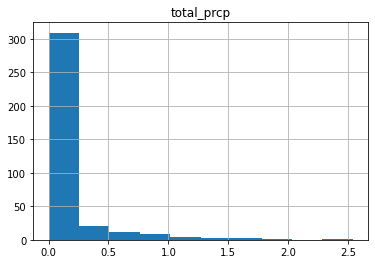

In [22]:
# temperature
df_weather.hist(column ="total_prcp")

array([[<AxesSubplot:title={'center':'total_snow'}>]], dtype=object)

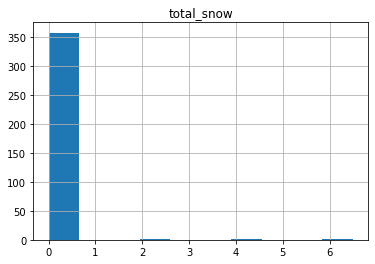

In [23]:
df_weather.hist(column ="total_snow")

array([[<AxesSubplot:title={'center':'max_temp'}>]], dtype=object)

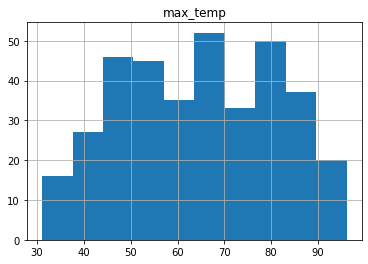

In [24]:
df_weather.hist(column="max_temp")

## 3) Initializing Variables

In [25]:
# Create a variable that groups all days that are "rainy" as a 1 if daily precipation is greater than 0.25 incehs and if not a 0

df_weather['rainy_day'] = np.where(df_weather['total_prcp']> 0.25, "rainy", "not rainy")

In [26]:
# Create a variable that groups all days that are "snowy" as a 1 if daily snowfall is greater than 2.0 incehs and if not a 0

df_weather['snowy_day'] = np.where(df_weather['total_snow']> 2.0, "snow", "not snowy")

In [27]:
# Create a variable that groups all days that are "hot" as a 1 if daily max temp is greater than 80.0 degrees fahrenheit and if not a 0


df_weather['hot_day'] = np.where(df_weather['max_temp']> 80.0, "hot", "not hot")

In [28]:
# Create a variable that groups all days that are "cold" as a 1 if daily max temp is less than 40 degrees fahrenheit and if not a 0


df_weather['cold_day'] = np.where(df_weather['max_temp']< 40.0, "cold", "not cold")

In [29]:
df_weather.head()

,date,max_temp,total_prcp,total_snow,rainy_day,snowy_day,hot_day,cold_day
0,2020-01-01,41.00,0.000000,0.0,not rainy,not snowy,not hot,not cold
1,2020-01-02,48.92,0.000000,0.0,not rainy,not snowy,not hot,not cold
2,2020-01-03,48.92,0.149606,0.0,not rainy,not snowy,not hot,not cold
3,2020-01-04,51.08,0.271654,0.0,rainy,not snowy,not hot,not cold
4,2020-01-05,42.08,0.000000,0.0,not rainy,not snowy,not hot,not cold


## 4) Save to local

In [30]:
df_weather.to_csv('nyc_weather.csv')

# Cleaning MTAData

In [31]:
# Convert to date_time

In [32]:
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

In [33]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(20)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
9732218,R514,R094,00-05-00,ASTORIA BLVD,2020-01-18 23:00:00,2
6885156,R110,R027,01-00-02,WALL ST,2020-12-15 07:00:00,2
6885154,R110,R027,01-00-02,WALL ST,2020-12-14 23:00:00,2
9732219,R514,R094,00-05-00,ASTORIA BLVD,2020-01-19 03:00:00,2
9732235,R514,R094,00-05-00,ASTORIA BLVD,2020-01-21 19:00:00,2
9732217,R514,R094,00-05-00,ASTORIA BLVD,2020-01-18 19:00:00,2
5977407,N701,R571,00-00-00,86 ST-2 AVE,2020-09-24 09:00:00,2
9732216,R514,R094,00-05-00,ASTORIA BLVD,2020-01-18 15:00:00,2
9732215,R514,R094,00-05-00,ASTORIA BLVD,2020-01-18 11:00:00,2
1745184,H009,R235,00-06-03,BEDFORD AV,2020-08-12 16:00:00,2


In [34]:
# Get rid of the duplicate entry
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [35]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(20)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-12-28 03:00:00,1
7213435,R138,R293,00-03-02,34 ST-PENN STA,2020-05-05 22:00:00,1
7213437,R138,R293,00-03-02,34 ST-PENN STA,2020-05-06 06:00:00,1
7213438,R138,R293,00-03-02,34 ST-PENN STA,2020-05-06 10:00:00,1
7213439,R138,R293,00-03-02,34 ST-PENN STA,2020-05-06 14:00:00,1
7213440,R138,R293,00-03-02,34 ST-PENN STA,2020-05-06 18:00:00,1
7213441,R138,R293,00-03-02,34 ST-PENN STA,2020-05-06 22:00:00,1
7213442,R138,R293,00-03-02,34 ST-PENN STA,2020-05-07 02:00:00,1
7213443,R138,R293,00-03-02,34 ST-PENN STA,2020-05-07 06:00:00,1
7213444,R138,R293,00-03-02,34 ST-PENN STA,2020-05-07 10:00:00,1


In [36]:
df.dtypes

DATE_TIME                                                               datetime64[ns]
C/A                                                                             object
UNIT                                                                            object
SCP                                                                             object
STATION                                                                         object
LINENAME                                                                        object
DIVISION                                                                        object
DESC                                                                            object
ENTRIES                                                                          int64
EXITS                                                                            int64
dtype: object

In [37]:
# create a date only variable (remove hours and minutes)

df['DATE'] = df['DATE_TIME'].dt.date
df.head()
df.dtypes

DATE_TIME                                                               datetime64[ns]
C/A                                                                             object
UNIT                                                                            object
SCP                                                                             object
STATION                                                                         object
LINENAME                                                                        object
DIVISION                                                                        object
DESC                                                                            object
ENTRIES                                                                          int64
EXITS                                                                            int64
DATE                                                                            object
dtype: object

### Back to cleaning MTA Data...

In [38]:
# Creating a dataframe grouping by day

turnstiles_daily = (df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [39]:
turnstiles_daily.head(10)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-12-28,7325143
1,A002,R051,02-00-00,59 ST,2019-12-29,7325774
2,A002,R051,02-00-00,59 ST,2019-12-30,7326944
3,A002,R051,02-00-00,59 ST,2019-12-31,7327981
4,A002,R051,02-00-00,59 ST,2020-01-01,7328499
5,A002,R051,02-00-00,59 ST,2020-01-02,7329882
6,A002,R051,02-00-00,59 ST,2020-01-03,7331169
7,A002,R051,02-00-00,59 ST,2020-01-04,7331951
8,A002,R051,02-00-00,59 ST,2020-01-05,7332543
9,A002,R051,02-00-00,59 ST,2020-01-06,7333879


In [40]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-40-3a945374269e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [41]:
# sanity check

turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,2019-12-28,7325143,NaN,NaN
1,A002,R051,02-00-00,59 ST,2019-12-29,7325774,2019-12-28,7325143.0
2,A002,R051,02-00-00,59 ST,2019-12-30,7326944,2019-12-29,7325774.0
3,A002,R051,02-00-00,59 ST,2019-12-31,7327981,2019-12-30,7326944.0
4,A002,R051,02-00-00,59 ST,2020-01-01,7328499,2019-12-31,7327981.0


In [42]:
# Drop the rows for the earliest date in the df

turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [43]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,2019-12-29,7325774,2019-12-28,7325143.0
2,A002,R051,02-00-00,59 ST,2019-12-30,7326944,2019-12-29,7325774.0
3,A002,R051,02-00-00,59 ST,2019-12-31,7327981,2019-12-30,7326944.0
4,A002,R051,02-00-00,59 ST,2020-01-01,7328499,2019-12-31,7327981.0
5,A002,R051,02-00-00,59 ST,2020-01-02,7329882,2020-01-01,7328499.0


## Handling negative values

In [44]:
# Checking where previous entries are greater than current

turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
4040,A002,R051,02-06-00,59 ST,2020-02-13,889,2020-02-12,82625.0
4127,A002,R051,02-06-00,59 ST,2020-09-12,27005,2020-05-09,44341.0
5795,A006,R079,00-00-04,5 AV/59 ST,2020-04-13,22,2020-04-12,7896791.0
6125,A006,R079,00-03-00,5 AV/59 ST,2020-03-10,60,2020-03-09,9437429.0
9065,A007,R079,01-06-03,5 AV/59 ST,2020-04-07,4,2020-04-06,7832194.0


In [45]:
# Let's see how many stations have this problem

(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A    UNIT  SCP       STATION        
A002   R051  02-06-00  59 ST                2
A006   R079  00-00-04  5 AV/59 ST           1
             00-03-00  5 AV/59 ST           1
A007   R079  01-06-03  5 AV/59 ST           1
A011   R080  01-03-00  57 ST-7 AV         363
                                         ... 
R728   R226  00-00-00  GUN HILL RD          1
             00-00-01  GUN HILL RD          1
R729   R292  00-00-01  BAYCHESTER AV        1
R730   R431  00-00-04  EASTCHSTER/DYRE    361
TRAM1  R468  00-00-01  RIT-MANHATTAN        1
Length: 649, dtype: int64

In [46]:
# Create a function to handles instances where counter is descending

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

22 7896791.0
60 9437429.0
4 7832194.0
9 1562921334.0
289 3055256.0
348 1237351900.0
459077 85175465.0
123 1630877.0
20 2642748.0
848 1180101.0
305 7251354.0
658 1203534.0
26 3963030.0
6 6777428.0
1066 1091335.0
408 4676418.0
12 1309708904.0
294 6612092.0
107 8235039.0
210 2427404.0
379 1208236.0
93 1178971.0
88 1197880.0
262182 6657224.0
5309717 100663522.0
2031759 368226.0
170526823 1802952.0
248 1264348.0
36 5675074.0
25 8800439.0
223936549 167098.0
1294 6496220.0
1560308511 6140951.0
393220 118199797.0
455 2822958.0
524338 67889725.0
372 4971113.0
86 8360145.0
475957878 7480530.0
544 475738131.0
2920 3117927.0
618862 2634131.0
230 955727806.0
17126295 19676957.0
5177693 17134751.0
15065838 17126282.0
25525735 15065804.0
12309516 25525671.0
1730 1455549.0
233 2297325.0
219 1875169.0
631046281 246545.0
112 631050303.0
606 8096346.0
1136721145 6439404.0
212 3145253.0
72 1100765.0
590069 1906617.0
91 4038371.0
172229024 8843948.0
97 3953593.0
20 2635368.0
95 3571824.0
157 3563454.0
144 

In [47]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,2019-12-29,7325774,2019-12-28,7325143.0,631.0
2,A002,R051,02-00-00,59 ST,2019-12-30,7326944,2019-12-29,7325774.0,1170.0
3,A002,R051,02-00-00,59 ST,2019-12-31,7327981,2019-12-30,7326944.0,1037.0
4,A002,R051,02-00-00,59 ST,2020-01-01,7328499,2019-12-31,7327981.0,518.0
5,A002,R051,02-00-00,59 ST,2020-01-02,7329882,2020-01-01,7328499.0,1383.0


# Merging Weather Dataset

In [48]:
# Converting turnstile daily "date" variable to be the same type as in the mta data 
turnstiles_daily['DATE'] = pd.to_datetime(turnstiles_daily['DATE'])
turnstiles_daily.dtypes

C/A                      object
UNIT                     object
SCP                      object
STATION                  object
DATE             datetime64[ns]
ENTRIES                   int64
PREV_DATE                object
PREV_ENTRIES            float64
DAILY_ENTRIES           float64
dtype: object

In [49]:
turnstiles_daily_weather = pd.merge(left = turnstiles_daily, right = df_weather, left_on = 'DATE', right_on = 'date')

# Analysis (Excludes Weather)

In [50]:
# Searching for outliers

C:\Users\Andrew\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DAILY_ENTRIES', ylabel='Density'>

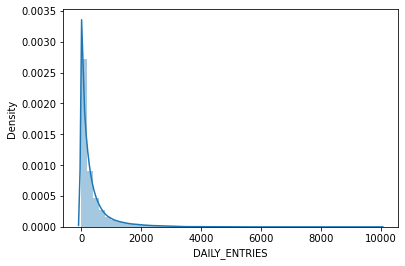

In [51]:
sns.distplot(turnstiles_daily['DAILY_ENTRIES']
             [turnstiles_daily['DAILY_ENTRIES'] < 10000])

In [52]:
# Given the limited number of entries above 2000 and those with less than 0 still we delete all below that number

In [53]:
turnstiles_daily.drop(turnstiles_daily[turnstiles_daily['DAILY_ENTRIES'] > 2000].index, inplace = True) 

In [54]:
turnstiles_daily.head(10)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,2019-12-29,7325774,2019-12-28,7325143.0,631.0
2,A002,R051,02-00-00,59 ST,2019-12-30,7326944,2019-12-29,7325774.0,1170.0
3,A002,R051,02-00-00,59 ST,2019-12-31,7327981,2019-12-30,7326944.0,1037.0
4,A002,R051,02-00-00,59 ST,2020-01-01,7328499,2019-12-31,7327981.0,518.0
5,A002,R051,02-00-00,59 ST,2020-01-02,7329882,2020-01-01,7328499.0,1383.0
6,A002,R051,02-00-00,59 ST,2020-01-03,7331169,2020-01-02,7329882.0,1287.0
7,A002,R051,02-00-00,59 ST,2020-01-04,7331951,2020-01-03,7331169.0,782.0
8,A002,R051,02-00-00,59 ST,2020-01-05,7332543,2020-01-04,7331951.0,592.0
9,A002,R051,02-00-00,59 ST,2020-01-06,7333879,2020-01-05,7332543.0,1336.0
10,A002,R051,02-00-00,59 ST,2020-01-07,7335258,2020-01-06,7333879.0,1379.0


### At the station level

In [113]:
# calculate daily entries by station
stations_daily = \
(turnstiles_daily.groupby(['STATION','DATE'])['DAILY_ENTRIES'].sum()
                 .reset_index())

In [114]:
stations_daily.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,2019-12-29,2933.0
1,1 AV,2019-12-30,6672.0
2,1 AV,2019-12-31,5699.0
3,1 AV,2020-01-01,7253.0
4,1 AV,2020-01-02,6003.0


### Calculating the top 10 stations by cumulative 2020 rides

In [115]:
# top 10 stations by daily volume
# (sum across all days is a reasonable way to define this)
top10_stations_stations_only = \
    (stations_daily.groupby(['STATION'])['DAILY_ENTRIES'].sum()
                   .reset_index()
                   .sort_values(by='DAILY_ENTRIES',ascending=False) 
                   .STATION.head(10))

In [116]:
# Create a dataframe that is daily entries for only the top 10
stations_daily_top10 = \
   stations_daily[stations_daily['STATION'].isin(top10_stations_stations_only)]

In [117]:
# Creating a dataframe that includes total annual entries for only the top10
top10_stations = \
    stations_daily_top10.groupby(["STATION"])['DAILY_ENTRIES'].sum().reset_index().sort_values(by="DAILY_ENTRIES",ascending=False)

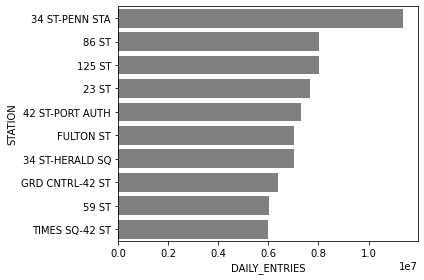

In [118]:
totals_plot = sns.barplot(x = 'DAILY_ENTRIES', y = "STATION",data=top10_stations,color="gray")
plt.tight_layout()
plt.savefig('cumulative_top_10.png')

In [119]:
# summing daily rides for the top 10 stations

daily_totals_top10 = \
    (stations_daily_top10.groupby(['DATE'])['DAILY_ENTRIES'].sum().reset_index())
daily_totals_top10

,DATE,DAILY_ENTRIES
0,2019-12-29,351169.0
1,2019-12-30,473175.0
2,2019-12-31,461834.0
3,2020-01-01,365802.0
4,2020-01-02,452605.0
...,...,...
358,2020-12-21,245033.0
359,2020-12-22,251595.0
360,2020-12-23,252719.0
361,2020-12-24,184699.0


### Time trends for top 10 stations

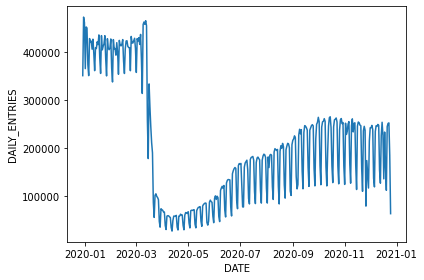

In [120]:
# top 10 stations aggregate trends
sns.lineplot(x = "DATE",y = "DAILY_ENTRIES",data=daily_totals_top10)
plt.tight_layout()
plt.savefig('daily_entry_time_series.png')

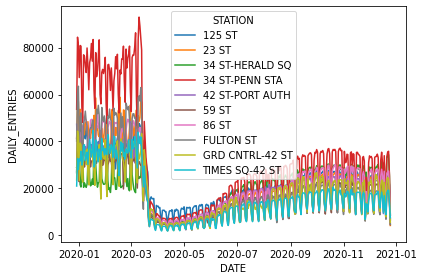

In [121]:
sns.lineplot(x = "DATE",y = "DAILY_ENTRIES",ci=None,hue='STATION',data=stations_daily_top10)
plt.tight_layout()
plt.savefig('daily_entry_time_series_individual.png')

In [122]:
# The above graph suggests taht all of the top units followed similar patterns, 
# I create a mask to limit the dataset to be since march to reduce the y axis and more closely compare trends

In [123]:
# Converting to datetime to allow filtering on date

In [124]:
stations_daily_top10.dtypes

STATION                  object
DATE             datetime64[ns]
DAILY_ENTRIES           float64
dtype: object

In [125]:
stations_daily_top10['DATE'] = pd.to_datetime(stations_daily_top10['DATE'])

<ipython-input-125-1d48a5ab4600>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_daily_top10['DATE'] = pd.to_datetime(stations_daily_top10['DATE'])


In [126]:
stations_daily_top10.dtypes

STATION                  object
DATE             datetime64[ns]
DAILY_ENTRIES           float64
dtype: object

In [127]:
start_date = '03-15-2020'

In [128]:
mask = (stations_daily_top10['DATE'] > start_date)

In [129]:
stations_daily_top10_since_mid_march = stations_daily_top10.loc[mask]

In [130]:
stations_daily_top10_since_mid_march.head()

,STATION,DATE,DAILY_ENTRIES
3329,125 ST,2020-03-16,32596.0
3330,125 ST,2020-03-17,33481.0
3331,125 ST,2020-03-18,31506.0
3332,125 ST,2020-03-19,28489.0
3333,125 ST,2020-03-20,27013.0


<AxesSubplot:xlabel='DATE', ylabel='DAILY_ENTRIES'>

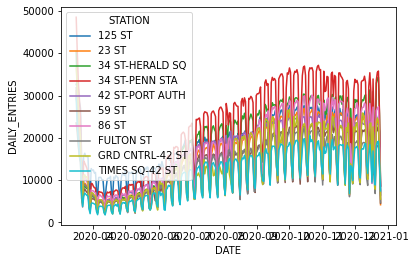

In [131]:
# Regraphing lineplot with dates reduced to since March
sns.lineplot(x = "DATE",y ="DAILY_ENTRIES",ci=None,hue='STATION',data=stations_daily_top10_since_mid_march)

### Focussing on days of the week

In [132]:
# creating a column for day of week in top 10 dataframe

In [133]:
stations_daily_top10['day_of_week'] = stations_daily_top10['DATE'].dt.day_name()

<ipython-input-133-6a36ab525984>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_daily_top10['day_of_week'] = stations_daily_top10['DATE'].dt.day_name()


In [134]:
stations_daily_top10.head()

,STATION,DATE,DAILY_ENTRIES,day_of_week
3251,125 ST,2019-12-29,27088.0,Sunday
3252,125 ST,2019-12-30,40012.0,Monday
3253,125 ST,2019-12-31,43837.0,Tuesday
3254,125 ST,2020-01-01,33529.0,Wednesday
3255,125 ST,2020-01-02,45638.0,Thursday


In [135]:
totals_top_10_day_of_week = \
    (stations_daily_top10.groupby(['day_of_week'])['DAILY_ENTRIES']).sum().reset_index().sort_values(by='DAILY_ENTRIES',ascending=False)

In [136]:
totals_top_10_day_of_week.head(10)

,day_of_week,DAILY_ENTRIES
5,Tuesday,12013899.0
6,Wednesday,11925389.0
0,Friday,11693876.0
1,Monday,11684626.0
4,Thursday,11669848.0
2,Saturday,8469056.0
3,Sunday,7376438.0


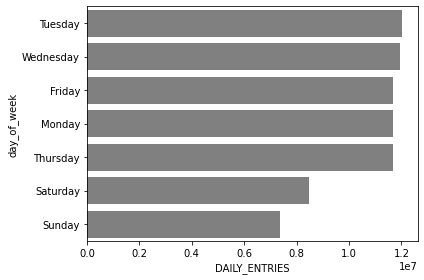

In [137]:
sns.barplot(x = 'DAILY_ENTRIES',y = "day_of_week",data=totals_top_10_day_of_week,color="gray",ci="68")
plt.tight_layout()
plt.savefig('day_of_week.png')

# Weather Analysis

In [138]:
# We want a dataframe with daily sums for the top 10 over our time range

In [139]:
# Merging daily_totals_top 10 with weathe dataset

daily_totals_weather_top10 = pd.merge(left = daily_totals_top10, right = df_weather, left_on = 'DATE', right_on = 'date')
daily_totals_weather_top10.head()

,DATE,DAILY_ENTRIES,date,max_temp,total_prcp,total_snow,rainy_day,snowy_day,hot_day,cold_day
0,2020-01-01,365802.0,2020-01-01,41.00,0.000000,0.0,not rainy,not snowy,not hot,not cold
1,2020-01-02,452605.0,2020-01-02,48.92,0.000000,0.0,not rainy,not snowy,not hot,not cold
2,2020-01-03,450432.0,2020-01-03,48.92,0.149606,0.0,not rainy,not snowy,not hot,not cold
3,2020-01-04,374201.0,2020-01-04,51.08,0.271654,0.0,rainy,not snowy,not hot,not cold
4,2020-01-05,351184.0,2020-01-05,42.08,0.000000,0.0,not rainy,not snowy,not hot,not cold


In [140]:
# Restrict data to mid-march, cannot compare randomly distributed weather events pre-pandemic
start_date = '03-15-2020'
mask = (daily_totals_weather_top10['DATE'] > start_date)
daily_totals_weather_top10_mid_march = daily_totals_weather_top10[mask]

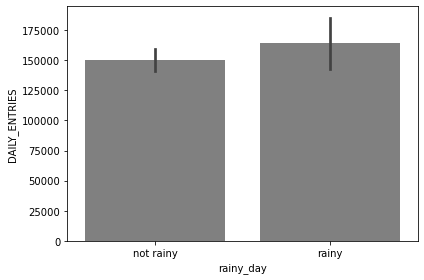

In [141]:
# Comparing rainy days
sns.barplot(x = 'rainy_day', y = "DAILY_ENTRIES",data=daily_totals_weather_top10_mid_march,color="gray")
plt.tight_layout()
plt.savefig('rainy_day.png')

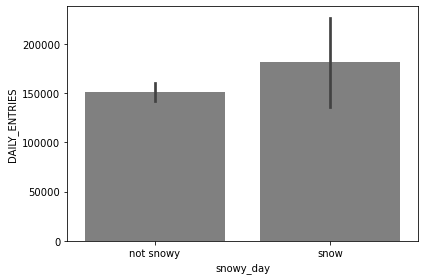

In [142]:
# Comparing
sns.barplot(x = 'snowy_day', y = "DAILY_ENTRIES",data=daily_totals_weather_top10_mid_march,color="gray")
plt.tight_layout()
plt.savefig('snowy_day.png')

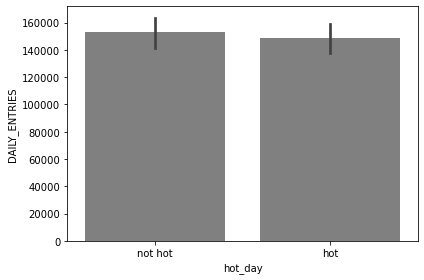

In [143]:
sns.barplot(x = 'hot_day', y = "DAILY_ENTRIES",data=daily_totals_weather_top10_mid_march,color="gray")
plt.tight_layout()
plt.savefig('hot_day.png')

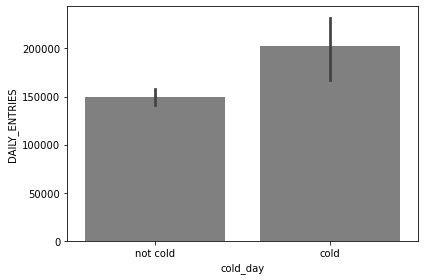

In [144]:
sns.barplot(x = 'cold_day', y = "DAILY_ENTRIES",data=daily_totals_weather_top10_mid_march,color="gray")
plt.tight_layout()
plt.savefig('cold_day.png')

In [145]:
# Restrict data to mid-march, cannot compare randomly distributed weather events pre-pandemic
start_date = '03-15-2020'
mask = (daily_totals_weather_top10['DATE'] > start_date)
daily_totals_weather_top10_mid_march = daily_totals_weather_top10[mask]

# Comparison stats for presentation

In [146]:
# Want to calculate the average cumulative entries

In [147]:
all_cumulative_stations = \
    (stations_daily.groupby(['STATION'])['DAILY_ENTRIES'].sum()
                   .reset_index()
                   .sort_values(by='DAILY_ENTRIES',ascending=False))

In [148]:
cum_average = all_cumulative_stations['DAILY_ENTRIES'].mean()

In [149]:
# create a new column in the top10_stations dataframe that represents the multiple of the average (i.e. 5x volume)

In [150]:
#top10_stations['multiple_average'] = [df['DAILY_ENTRIES']/cum_average for 

In [151]:
top10_stations['multiple_average'] = [item/cum_average for item in top10_stations['DAILY_ENTRIES']]

In [152]:
top10_stations

,STATION,DAILY_ENTRIES,multiple_average
3,34 ST-PENN STA,11389339.0,8.177166
6,86 ST,8022167.0,5.759649
0,125 ST,8005955.0,5.748009
1,23 ST,7652802.0,5.494457
4,42 ST-PORT AUTH,7284479.0,5.230013
7,FULTON ST,7037484.0,5.052679
2,34 ST-HERALD SQ,7031880.0,5.048656
8,GRD CNTRL-42 ST,6387444.0,4.585972
5,59 ST,6045709.0,4.340618
9,TIMES SQ-42 ST,5975873.0,4.290478


In [5]:
###testing